<a href="https://colab.research.google.com/github/spirosChv/python-neuro-intro-imbizo2026/blob/main/intro_to_python_imbizo2026_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Synaptic Transmission

In Part 1, we stimulated the neuron with a constant current ($I$), like a scientist injecting electricity with an electrode. In the real brain, however, neurons receive signals from other neurons via **Synapses**.

### How a Synapse Works
1.  **Presynaptic Spike:** An upstream neuron fires a spike.
2.  **Neurotransmitter Release:** Chemicals cross the gap (synapse) and bind to the downstream neuron.
3.  **Conductance Change:** Ion channels open, changing the **Synaptic Conductance ($g_{syn}$)**.
4.  **Current Flow:** Ions flow into the cell, changing the voltage.



[Image of chemical synapse structure]


## 1. The Mathematical Model
We need to model the conductance $g_{syn}$.
* **Decay:** When no spikes arrive, the channels close exponentially:
    $$\tau_{syn} \frac{dg_{syn}}{dt} = -g_{syn}$$
* **Kick:** When a spike arrives, $g_{syn}$ instantly increases by a weight $w$.

The total current entering the neuron is now:
$$I_{syn} = -g_{syn}(t) \cdot (V - E_{syn})$$

In [5]:
# =============================================================================
# 0. Defining Model Parameters
# =============================================================================

# Membrane Time Constant (tau_m)
# Unit: milliseconds (ms)
tau = 20.0

# Resting Potential (E_L)
# Unit: millivolts (mV)
E_L = -70.0

# Membrane Resistance (R_m)
# Unit: MegaOhms (MOhms)
R = 10.0

# Input Current (I)
# Unit: nanoAmperes (nA)
I = 10

# Threshold Potential (V_th)
# If the voltage crosses this, the neuron fires.
V_th = -50.0

# Reset Potential (V_reset)
# After firing, the voltage returns here.
V_reset = -75.0

# Let's verify our variables by printing them
print("Parameters defined successfully.")
print("The Resting Potential is:", E_L, "mV")

Parameters defined successfully.
The Resting Potential is: -70.0 mV


In [6]:
# =============================================================================
# 1. Defining Synaptic Parameters
# =============================================================================

# Synaptic Time Constant (tau_syn)
# How fast the channels close (decay). Usually faster than the membrane tau.
tau_syn = 5.0  # ms

# Synaptic Weight (w)
# How much the conductance increases when a spike arrives.
w = 0.05       # microSiemens (arbitrary unit for this tutorial)

# Synaptic Reversal Potential (E_syn)
# For Excitatory synapses (Sodium), this is usually 0 mV.
# For Inhibitory synapses (Chloride), this is usually -75 mV.
E_syn = 0.0    # mV (Excitatory)

# Initialize conductance
g_syn = 0.0

print("Synapse parameters set.")
print("Excitatory synapse will pull voltage towards:", E_syn, "mV")

Synapse parameters set.
Excitatory synapse will pull voltage towards: 0.0 mV


## 2. Creating the Input (Spike Train)

We need to decide *when* the input spikes arrive.
We will create a list of "Input Spikes" that represents the activity of a presynaptic neuron.

* **0:** No spike at this time step.
* **1:** A spike arrives at this time step.

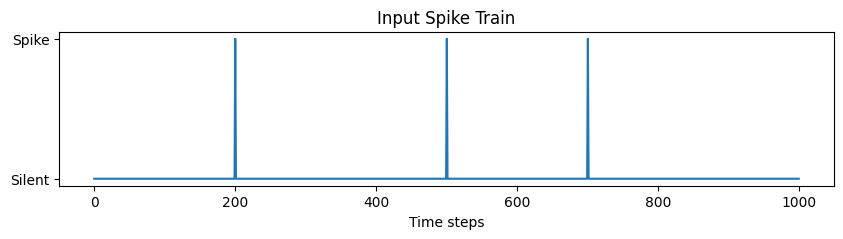

In [7]:
# =============================================================================
# 2. Generating Input Spikes
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np # We will use numpy for easier array handling

# Re-define time settings (just to be safe)
dt = 0.1
T = 100.0
num_steps = int(T / dt)

# Create an array of Zeros (Silent)
# "np.zeros" creates a list filled with 0.0
spikes = np.zeros(num_steps)

# Add spikes at specific times
# Let's put a spike at 20ms, 50ms, and 70ms.
# We must convert "Time" to "Step Index" (Time / dt)
spikes[int(20.0/dt)] = 1
spikes[int(50.0/dt)] = 1
spikes[int(70.0/dt)] = 1

# Let's plot the input to see it
plt.figure(figsize=(10, 2)) # Make the plot short and wide
plt.plot(spikes)
plt.title("Input Spike Train")
plt.xlabel("Time steps")
plt.yticks([0, 1], ["Silent", "Spike"]) # Label the Y-axis neatly
plt.show()

---
## Interlude: Introducing NumPy

You might have noticed a new command above: `import numpy as np`.

### What is NumPy?
**NumPy** (Numerical Python) is the most important library for science and engineering in Python.
While standard Python "Lists" are great for storing mixed data (like names and numbers), they are slow and clumsy for math.

**Why do we use it?**
1.  **Speed:** It calculates huge arrays of numbers instantly.
2.  **Math powers:** You can't multiply a normal Python list by 2 (it just duplicates the list!). With NumPy, you can multiply, divide, and add arrays just like vectors in math.
3.  **Convenience:** Functions like `np.zeros()` or `np.arange()` make setting up simulations much faster.

We usually shorten it to `np` to save time typing.

---
## 3. The Synaptic Loop

Now we run the simulation again. This loop is slightly busier than before.

Inside every time step, we must:
1.  **Check for Input:** Did a spike arrive from the other neuron? If yes, increase conductance ($g_{syn}$).
2.  **Update Conductance:** Allow $g_{syn}$ to decay exponentially.
3.  **Calculate Current:** Calculate the synaptic current $I_{syn}$ flowing through those open channels.
4.  **Update Voltage:** Use $I_{syn}$ to change the membrane potential $V$.

**The Equations:**
$$g_{syn}(t+\Delta t) = g_{syn}(t) - \frac{g_{syn}(t)}{\tau_{syn}} \Delta t + \text{Input}$$
$$I_{syn} = -g_{syn}(t) \cdot (V(t) - E_{syn})$$
$$\tau_m \frac{dV}{dt} = -(V - E_L) + R \cdot I_{syn}$$

In [8]:
# =============================================================================
# Running the Synaptic Simulation
# =============================================================================

# Initialize variables
V = E_L
g_syn = 0.0

# Storage lists
V_trace = [V]
g_trace = [g_syn]

for i in range(num_steps):

    # 1. Update Conductance (g_syn)
    # Decay step
    dg_dt = -g_syn / tau_syn
    g_syn = g_syn + dg_dt * dt

    # Input step: If there is a spike at this time i, add weight
    if spikes[i] > 0:
        g_syn = g_syn + w

    # 2. Calculate Synaptic Current (I_syn)
    # Ohm's Law for membranes: I = g * (V - E)
    # We add a negative sign because current flows IN
    I_syn = -g_syn * (V - E_syn)

    # 3. Update Membrane Potential (V)
    # Notice: We use I_syn instead of the constant I we used before
    dv_dt = ( -(V - E_L) + R * I_syn ) / tau
    V = V + dv_dt * dt

    # 4. Store values
    V_trace.append(V)
    g_trace.append(g_syn)

print("Simulation complete.")

Simulation complete.


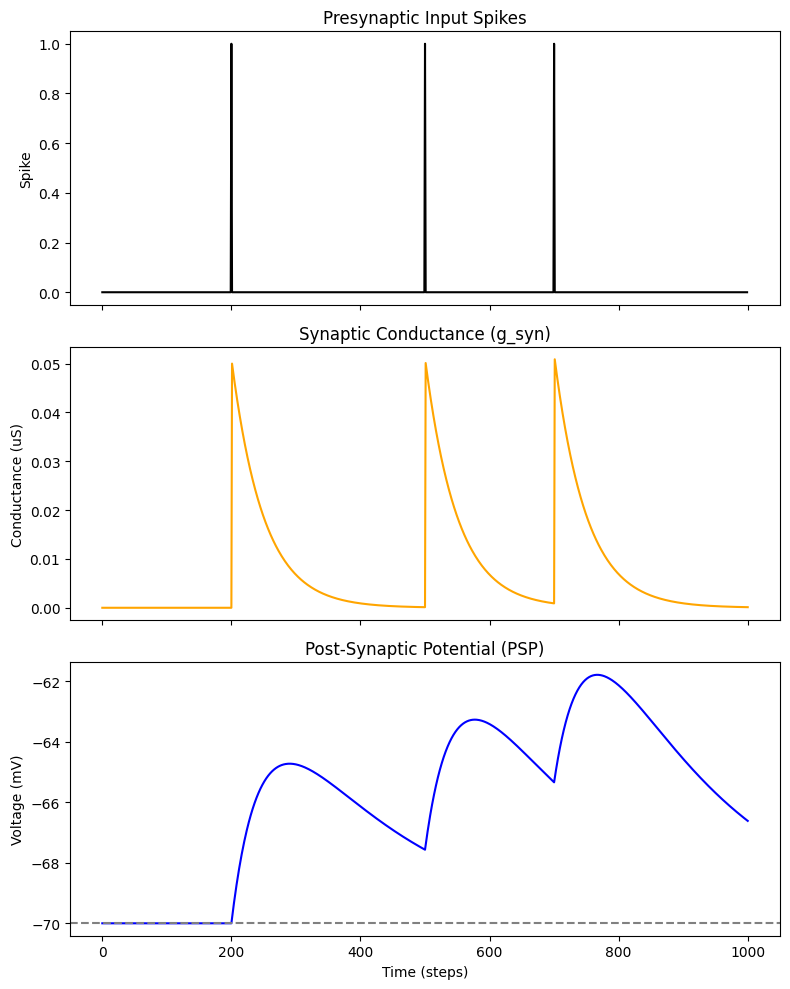

In [9]:
# =============================================================================
# Plotting Synaptic Activity
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Plot 1: Input Spikes
axes[0].plot(spikes, color='black')
axes[0].set_title('Presynaptic Input Spikes')
axes[0].set_ylabel('Spike')

# Plot 2: Conductance
axes[1].plot(g_trace, color='orange')
axes[1].set_title('Synaptic Conductance (g_syn)')
axes[1].set_ylabel('Conductance (uS)')

# Plot 3: Membrane Potential
axes[2].plot(V_trace, color='blue')
axes[2].set_title('Post-Synaptic Potential (PSP)')
axes[2].set_ylabel('Voltage (mV)')
axes[2].set_xlabel('Time (steps)')

# Add a dashed line for Resting Potential
axes[2].axhline(y=E_L, color='gray', linestyle='--', label='Resting')

plt.tight_layout()
plt.show()

---
## 4. Exercise: Excitatory vs. Inhibitory

In the simulation above, the voltage went **UP** when a spike arrived. We call this an **Excitatory Post-Synaptic Potential (EPSP)**. This happens because the Reversal Potential ($E_{syn} = 0$ mV) is higher than the Resting Potential.

But the brain also has **Inhibition**. Inhibitory neurons try to stop other neurons from firing. They do this by opening channels for ions (like Chloride) that pull the voltage **DOWN**.

### Your Challenge
1.  Copy the loop code from above.
2.  Change `E_syn` to **-80.0 mV** (Inhibitory Reversal Potential).
3.  Run the loop and plot the result.

**Question:** What happens to the voltage when a spike arrives now? Does it depolarize (go up) or hyperpolarize (go down)?

In [ ]:
# =============================================================================
# EXERCISE: Inhibitory Synapse
# =============================================================================

# 1. Change the parameter
E_syn_inhibitory = -80.0 # Inhibitory Reversal Potential

# 2. Reset variables
V = E_L
g_syn = 0.0
V_trace_inhibitory = [V]

# 3. Copy the loop logic here
for i in range(num_steps):

    # Update Conductance
    dg_dt = -g_syn / tau_syn
    g_syn = g_syn + dg_dt * dt
    if spikes[i] > 0:
        g_syn = g_syn + w

    # Calculate Current (using the NEW E_syn_inhibitory)
    # Note: We use E_syn_inhibitory here!
    I_syn = -g_syn * (V - E_syn_inhibitory)

    # Update Voltage
    dv_dt = ( -(V - E_L) + R * I_syn ) / tau
    V = V + dv_dt * dt

    V_trace_inhibitory.append(V)

# 4. Plot the result
plt.plot(V_trace_inhibitory)
plt.title('Inhibitory Post-Synaptic Potential (IPSP)')
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (steps)')
plt.axhline(y=E_L, color='gray', linestyle='--', label='Resting Potential')
plt.legend()
plt.show()